In [14]:
import os, random, glob, sys
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(linewidth=sys.maxsize)

np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=sys.maxsize)

sys.path.append("/home/railab/Workspace/CCBS/code/")

from core.func.cbs_basic import CBSSolver, CBSSolver_Cost
from core.func.icbs_complete import ICBS_Solver
from core.utils.utils import import_mapf_instance, inverse_sigmoid, get_scene_80, get_sum_of_cost, get_cbs_result

In [15]:
def dense_input_data(starts, goals):
    input_data = []

    all_data = [(sx, sy, gx, gy) for (sx, sy), (gx, gy) in zip(starts, goals)]

    for i, (start, goal) in enumerate(zip(starts, goals)):
        sx, sy = start
        gx, gy = goal
        dx, dy = gx-sx, gy-sy
        mag = np.sqrt(dx ** 2 + dy ** 2)

        if mag != 0:
            dx = dx / mag
            dy = dy / mag

        except_agent_data = all_data[:i] + all_data[i+1:]

        own_data = [sx, sy, gx, gy, dx, dy, mag]

        for (other_sx, other_sy, other_gx, other_gy) in except_agent_data:
            other_dx, other_dy = other_gx-other_sx, other_gy-other_sy
            other_mag = np.sqrt(other_dx ** 2 + other_dy ** 2)

            if other_mag != 0:
                other_dx = other_dx / other_mag
                other_dy = other_dy / other_mag

            own_data += [other_sx-sx, other_sy-sy, other_dx, other_dy, other_mag]

        own_data = np.array(own_data)
        input_data.append(own_data)
    
    return np.array(input_data)

In [16]:
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret

class CoordConv(nn.Module):
    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [17]:
class cnn_mlp(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(cnn_mlp, self).__init__()

        self.cnn_layers = nn.Sequential(
            CoordConv(2, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        )
        
        self.flatten = nn.Flatten()
        self.drop_out = nn.Dropout(.2)
        self.mlp_layers = nn.Sequential(
            nn.Linear(input_dim + 512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, output_dim),
        )
    
    def forward(self, obs_map, x):
        obs_feat = self.cnn_layers(obs_map)
        obs_feat = self.flatten(obs_feat)
        x = torch.cat((obs_feat, x), dim=1)
        x = self.mlp_layers(x)
        return x

Sorted_Normalized_no_vertex

In [18]:
test_scene_list = get_scene_80("test_68", "sorted_normalized_nonvertex", dataset="test")
method = "sorted_normalized_nonvertex"
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print("device: {}".format(device))

Total 1139 data loaded for test!
device: cuda:0


In [19]:
BATCH_SIZE = 20
LR = 1e-4
EPOCHS = 386
OBS_MAP = True

model = cnn_mlp(102, 1024)
mseloss = nn.MSELoss()
optm = torch.optim.Adam(model.parameters(), lr=1e-4)

model_name = "cnn_mlp_nonvertex"
loss_name = mseloss._get_name()

if OBS_MAP == False:
    save_path = "/home/railab/Workspace/CCBS/code/model_params/{}/{}/no_obs_map".format(model_name, loss_name)
elif OBS_MAP == True:
    save_path = "/home/railab/Workspace/CCBS/code/model_params/{}/{}/coord_h_val".format(model_name, loss_name)
else:
    raise ValueError(OBS_MAP)

if os.path.exists(save_path):
    saved_model_list = glob.glob(save_path + "/*.pt")
    saved_model_list.sort(key= lambda x : int(x.split("_")[-1][:-3]))
    last_model_file_name = saved_model_list[-1]
    previous_epochs = int(last_model_file_name.split("_")[-1][:-3])

    saved_loss_list = glob.glob(save_path + "/*.txt")[0]
    loss_list = []

    f = open(saved_loss_list, "r")
    saved_loss_list = f.readlines()
    loss_list = [float(saved_loss.rstrip()) for saved_loss in saved_loss_list]

    try:
        model.load_state_dict(torch.load(last_model_file_name))
        print("File name: {}".format(last_model_file_name.split("/")[-1]))
        print("Model loaded successfully")
    except:
        print("Model load Error!")
else:
    previous_epochs = 0
    loss_list = []
    print("There is no trained model!")

print("Model: {}\nLoss: {}\nIs obs_map: {}".format(model_name, loss_name, OBS_MAP))

File name: batch_20_lr_0.0001_epoch_1000.pt
Model loaded successfully
Model: cnn_mlp_nonvertex
Loss: MSELoss
Is obs_map: True


In [42]:
for scene in test_scene_list:
    if "27037" not in scene:
        continue

    print(scene)

    test_name = scene.split("/")[-2]
    scene_name = scene.split("/")[-1][:-4]

    map, starts, goals = import_mapf_instance(scene)

    obs_map = np.array([[int(val) for val in sublist] for sublist in map])
    obs_map = np.repeat(obs_map[np.newaxis,:,:], 20, axis=0)

    start_goals = [[(sx, sy), (gx, gy)] for ind, ((sx, sy), (gx, gy)) in enumerate(zip(starts, goals))]
    start_goals.sort(key=lambda x:(x[0], x[1]))
    sorted_starts = np.array([(sx, sy) for [(sx, sy), (gx, gy)] in start_goals])
    sorted_goals = np.array([(gx, gy) for [(sx, sy), (gx, gy)] in start_goals])
    input_data = dense_input_data(sorted_starts, sorted_goals)

    heatmap_path = "/home/railab/Workspace/CCBS/code/costmaps/Gaussian_Blur/" + test_name + "_heatmap/" + method + "/" + scene_name + ".npy"
    heatmap_data = np.load(heatmap_path, allow_pickle=True)

    h_map_path = "/home/railab/Workspace/CCBS/code/h_value_maps/" + method + "/" + scene_name + ".npy"
    h_map_array = np.load(h_map_path, allow_pickle=True)

    # Shuffle input, target pair
    data_pair_list = [[i, input, target, h_map] for i, (input, target, h_map) in enumerate(zip(input_data, heatmap_data, h_map_array))]
    input_list = []
    target_list = []
    h_val_list = []
    for pair in data_pair_list:
        input_list.append(pair[1])
        target_list.append(pair[2])
        h_val_list.append(pair[3])

    input = np.array(input_list)
    h_val = np.array(h_val_list)
    target_ = np.array(target_list)
    target_ = np.where(target_==0, 1e-4, target_)
    target_ = np.where(target_>=1, 1-(1e-4), target_)

    inverse_target = inverse_sigmoid(target_)

    obs_map = torch.reshape(torch.Tensor(obs_map), heatmap_data.shape)
    h_val = torch.reshape(torch.Tensor(h_val), heatmap_data.shape)

    conv_data = torch.cat((obs_map, h_val), axis=1)

    input_data = torch.Tensor(input)
    target = torch.Tensor(inverse_target)

    pred = model(conv_data, input_data)
    pred = torch.reshape(pred, target.shape)

    loss = mseloss(pred, target)

    pred = torch.sigmoid(pred)
    pred = pred.detach().numpy()

    pred = np.where(pred < 0.1, 0, pred)

    cbs_solver = CBSSolver(map, starts, goals)
    cbs_path, _, _, _ = cbs_solver.find_solution()

    print(cbs_path)

    icbs_solver = ICBS_Solver(map, starts, goals)
    icbs_path, icbs_gen_nodes, icbs_exp_nodes = icbs_solver.find_solution(False, "a_star")

    print(icbs_path)

    l_cbs_solver = CBSSolver_Cost(map, starts, goals, pred)
    l_cbs_path, _, _, _ = l_cbs_solver.find_solution()

    print(l_cbs_path)

    break

/home/railab/Workspace/CCBS/code/instances/generated/test_68/test_68_27037.txt
CBS Astar spent: 0.04631304740905762
CBS High level spent: 0.17862391471862793
[[(23, 18), (22, 18), (21, 18), (20, 18), (19, 18), (18, 18), (17, 18), (17, 19), (16, 19), (15, 19), (14, 19), (13, 19), (12, 19), (11, 19), (10, 19), (9, 19), (9, 20), (9, 21), (9, 22), (9, 23)], [(7, 4), (7, 5), (7, 6), (7, 7), (8, 7), (8, 8), (8, 9), (8, 10), (8, 11), (9, 11), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (11, 16), (11, 17), (11, 18), (11, 19), (12, 19), (13, 19), (14, 19), (15, 19), (16, 19), (17, 19), (18, 19), (19, 19), (20, 19), (21, 19), (22, 19)], [(29, 31), (28, 31), (27, 31), (27, 30), (27, 29), (27, 28), (27, 27), (27, 26), (27, 25), (27, 24), (27, 23), (27, 22), (27, 21), (27, 20), (27, 19), (27, 18), (27, 17), (27, 16), (27, 15), (27, 14), (27, 13)], [(19, 23), (18, 23), (18, 24), (18, 25), (18, 26), (18, 27), (18, 28)], [(6, 18), (5, 18), (5, 17), (5, 16), (5, 15), (5, 14), (4, 14), (

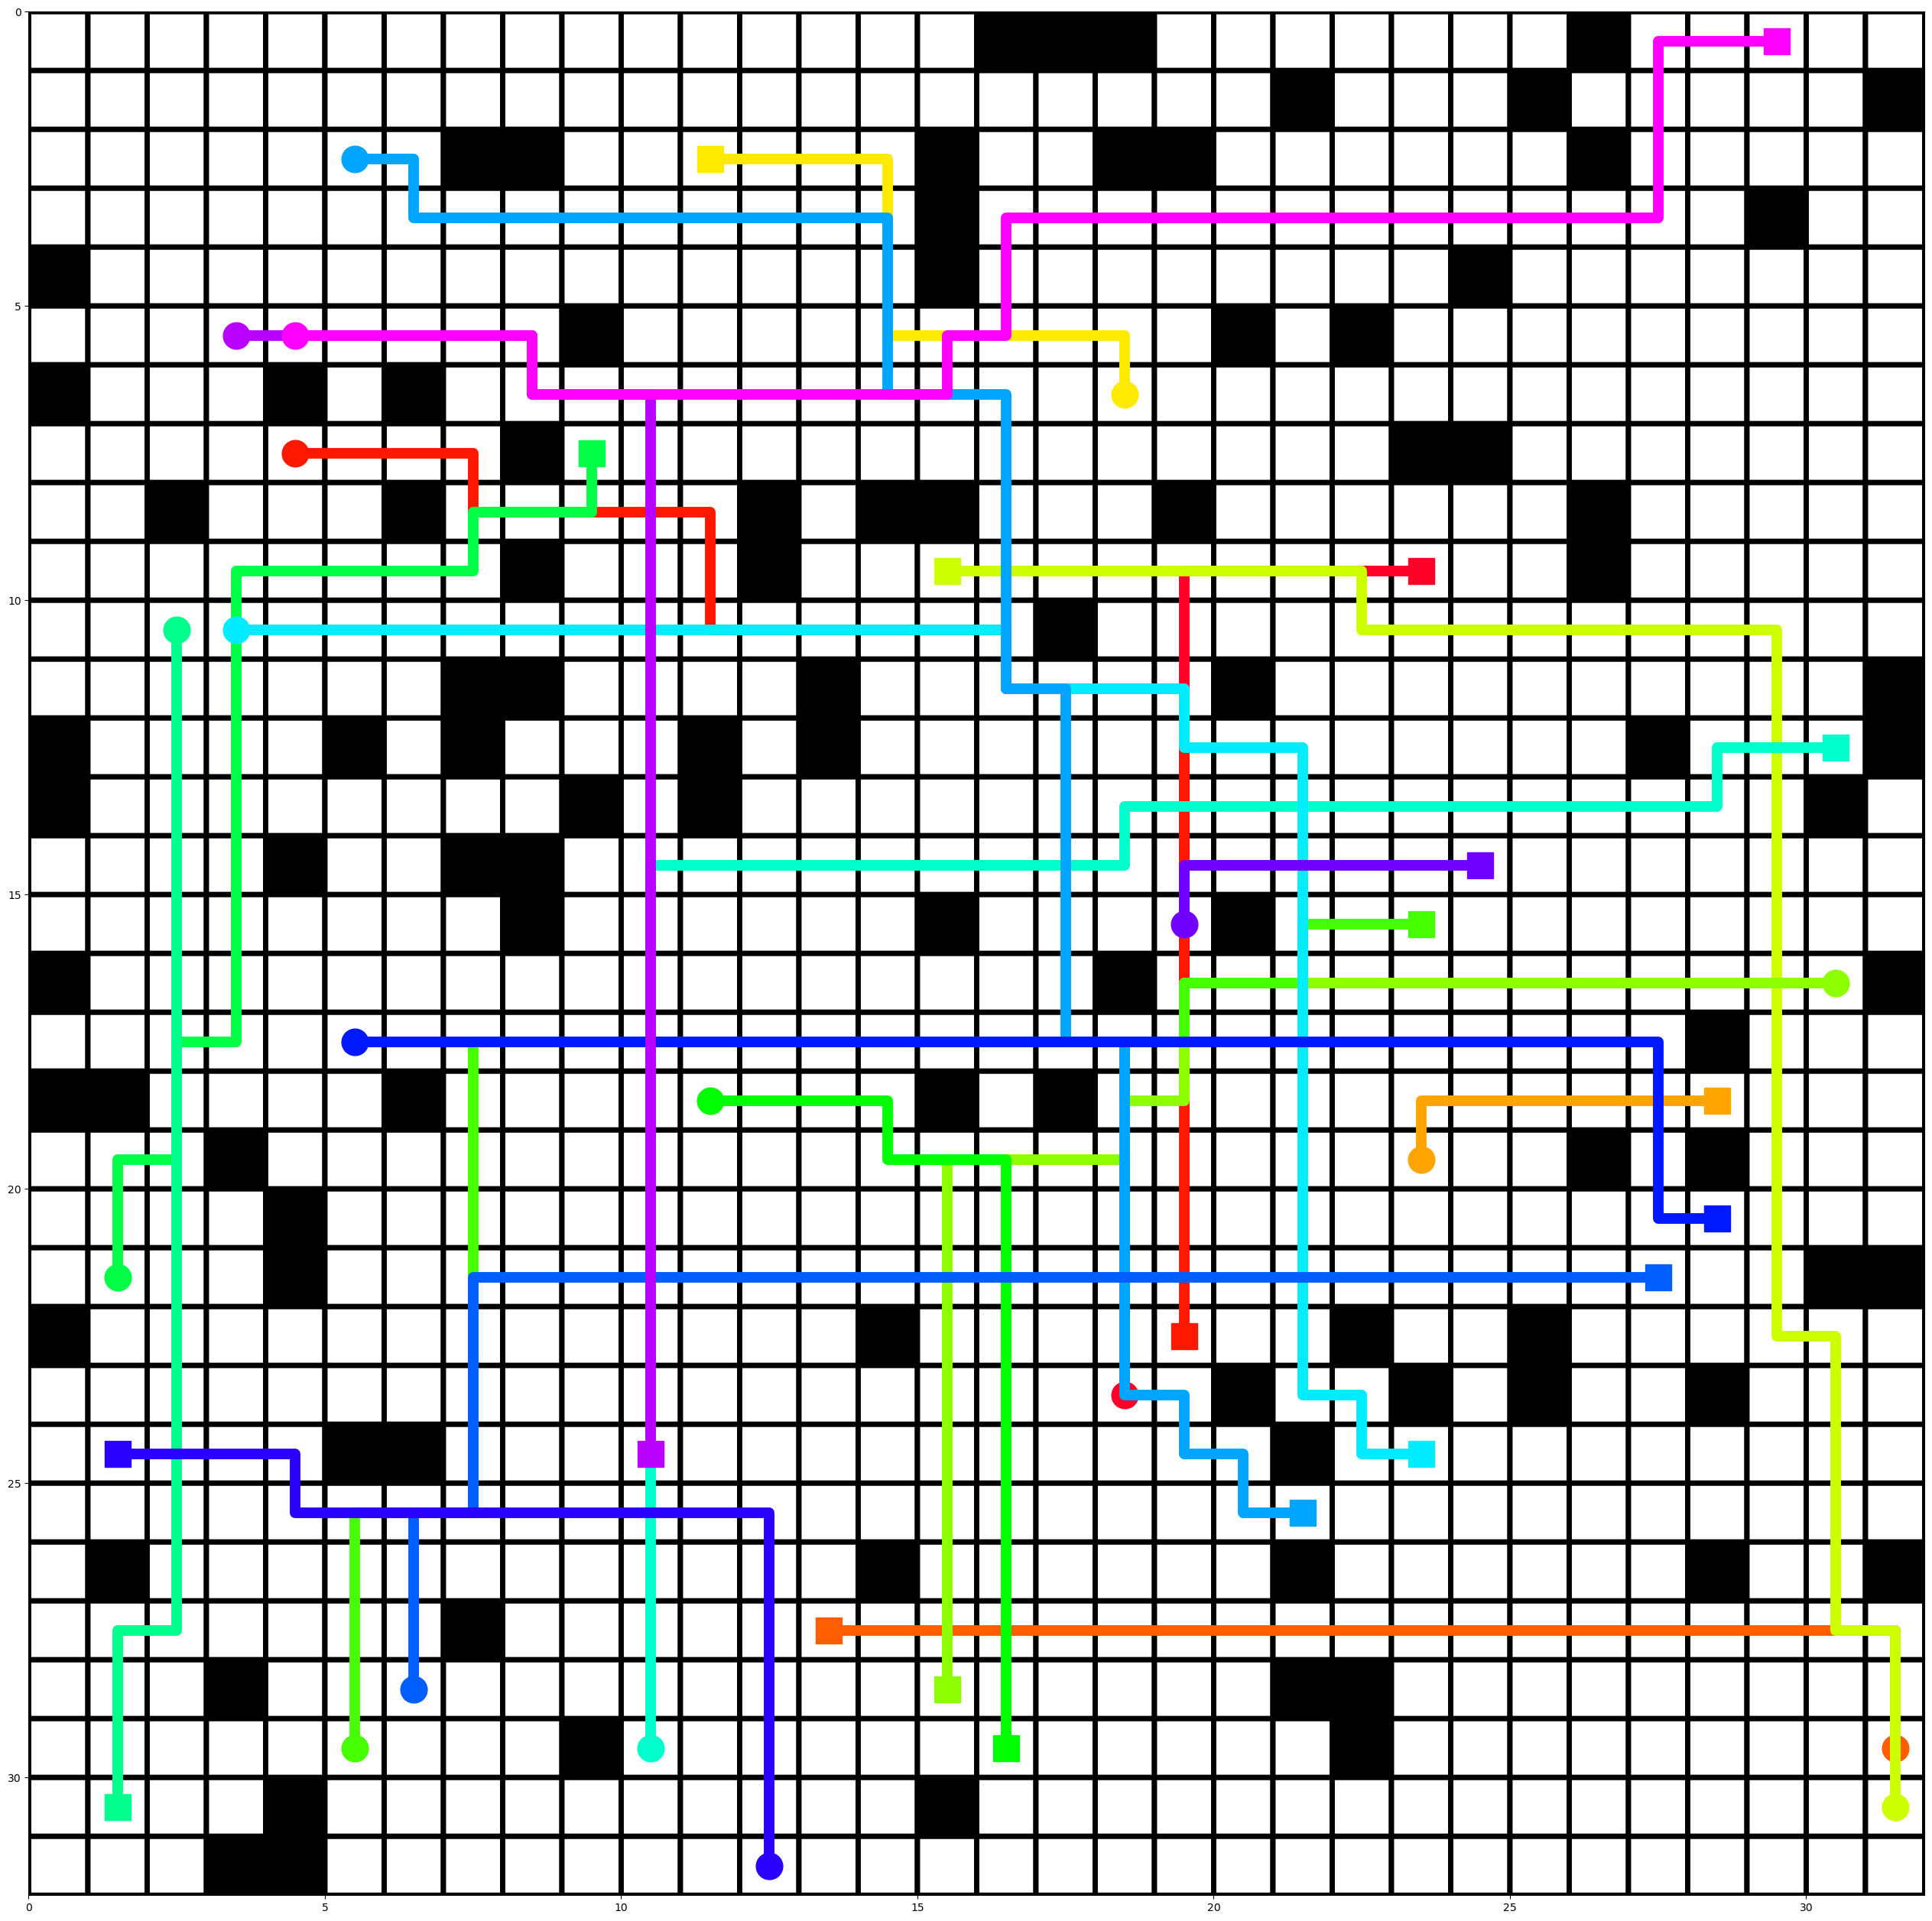

In [177]:
from matplotlib import colors

map_size = np.shape(map)
int_map = np.asarray([[int(i) for i in row] for row in map])
num_agents = len(starts)

grid_cmap = colors.ListedColormap(['White', 'Black'])

fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()
plt.pcolor(int_map[::],cmap=grid_cmap,edgecolor='k',linewidths=5)

# Init agents' individual color
agent_cmap = plt.get_cmap('gist_rainbow')
label_list = ["agent {}".format(str(i)) for i in range(num_agents)]

for i, (path, start, goal, label) in enumerate(zip(cbs_path, starts, goals, label_list)):
    # Plot agents
    # Start : circle, Goal : square
    # print(i/num_agents)
    c = agent_cmap(i/num_agents)
    plt.plot(start[1] + 0.5, start[0] + 0.5, marker='o', markersize=25, color=c, label=label)
    plt.plot(goal[1] + 0.5, goal[0] + 0.5, marker='s', markersize=25, color=c)

    path = np.asarray(path)
    plt.plot(path[:,1] + 0.5, path[:,0] + 0.5, color=c, linewidth=10.0)

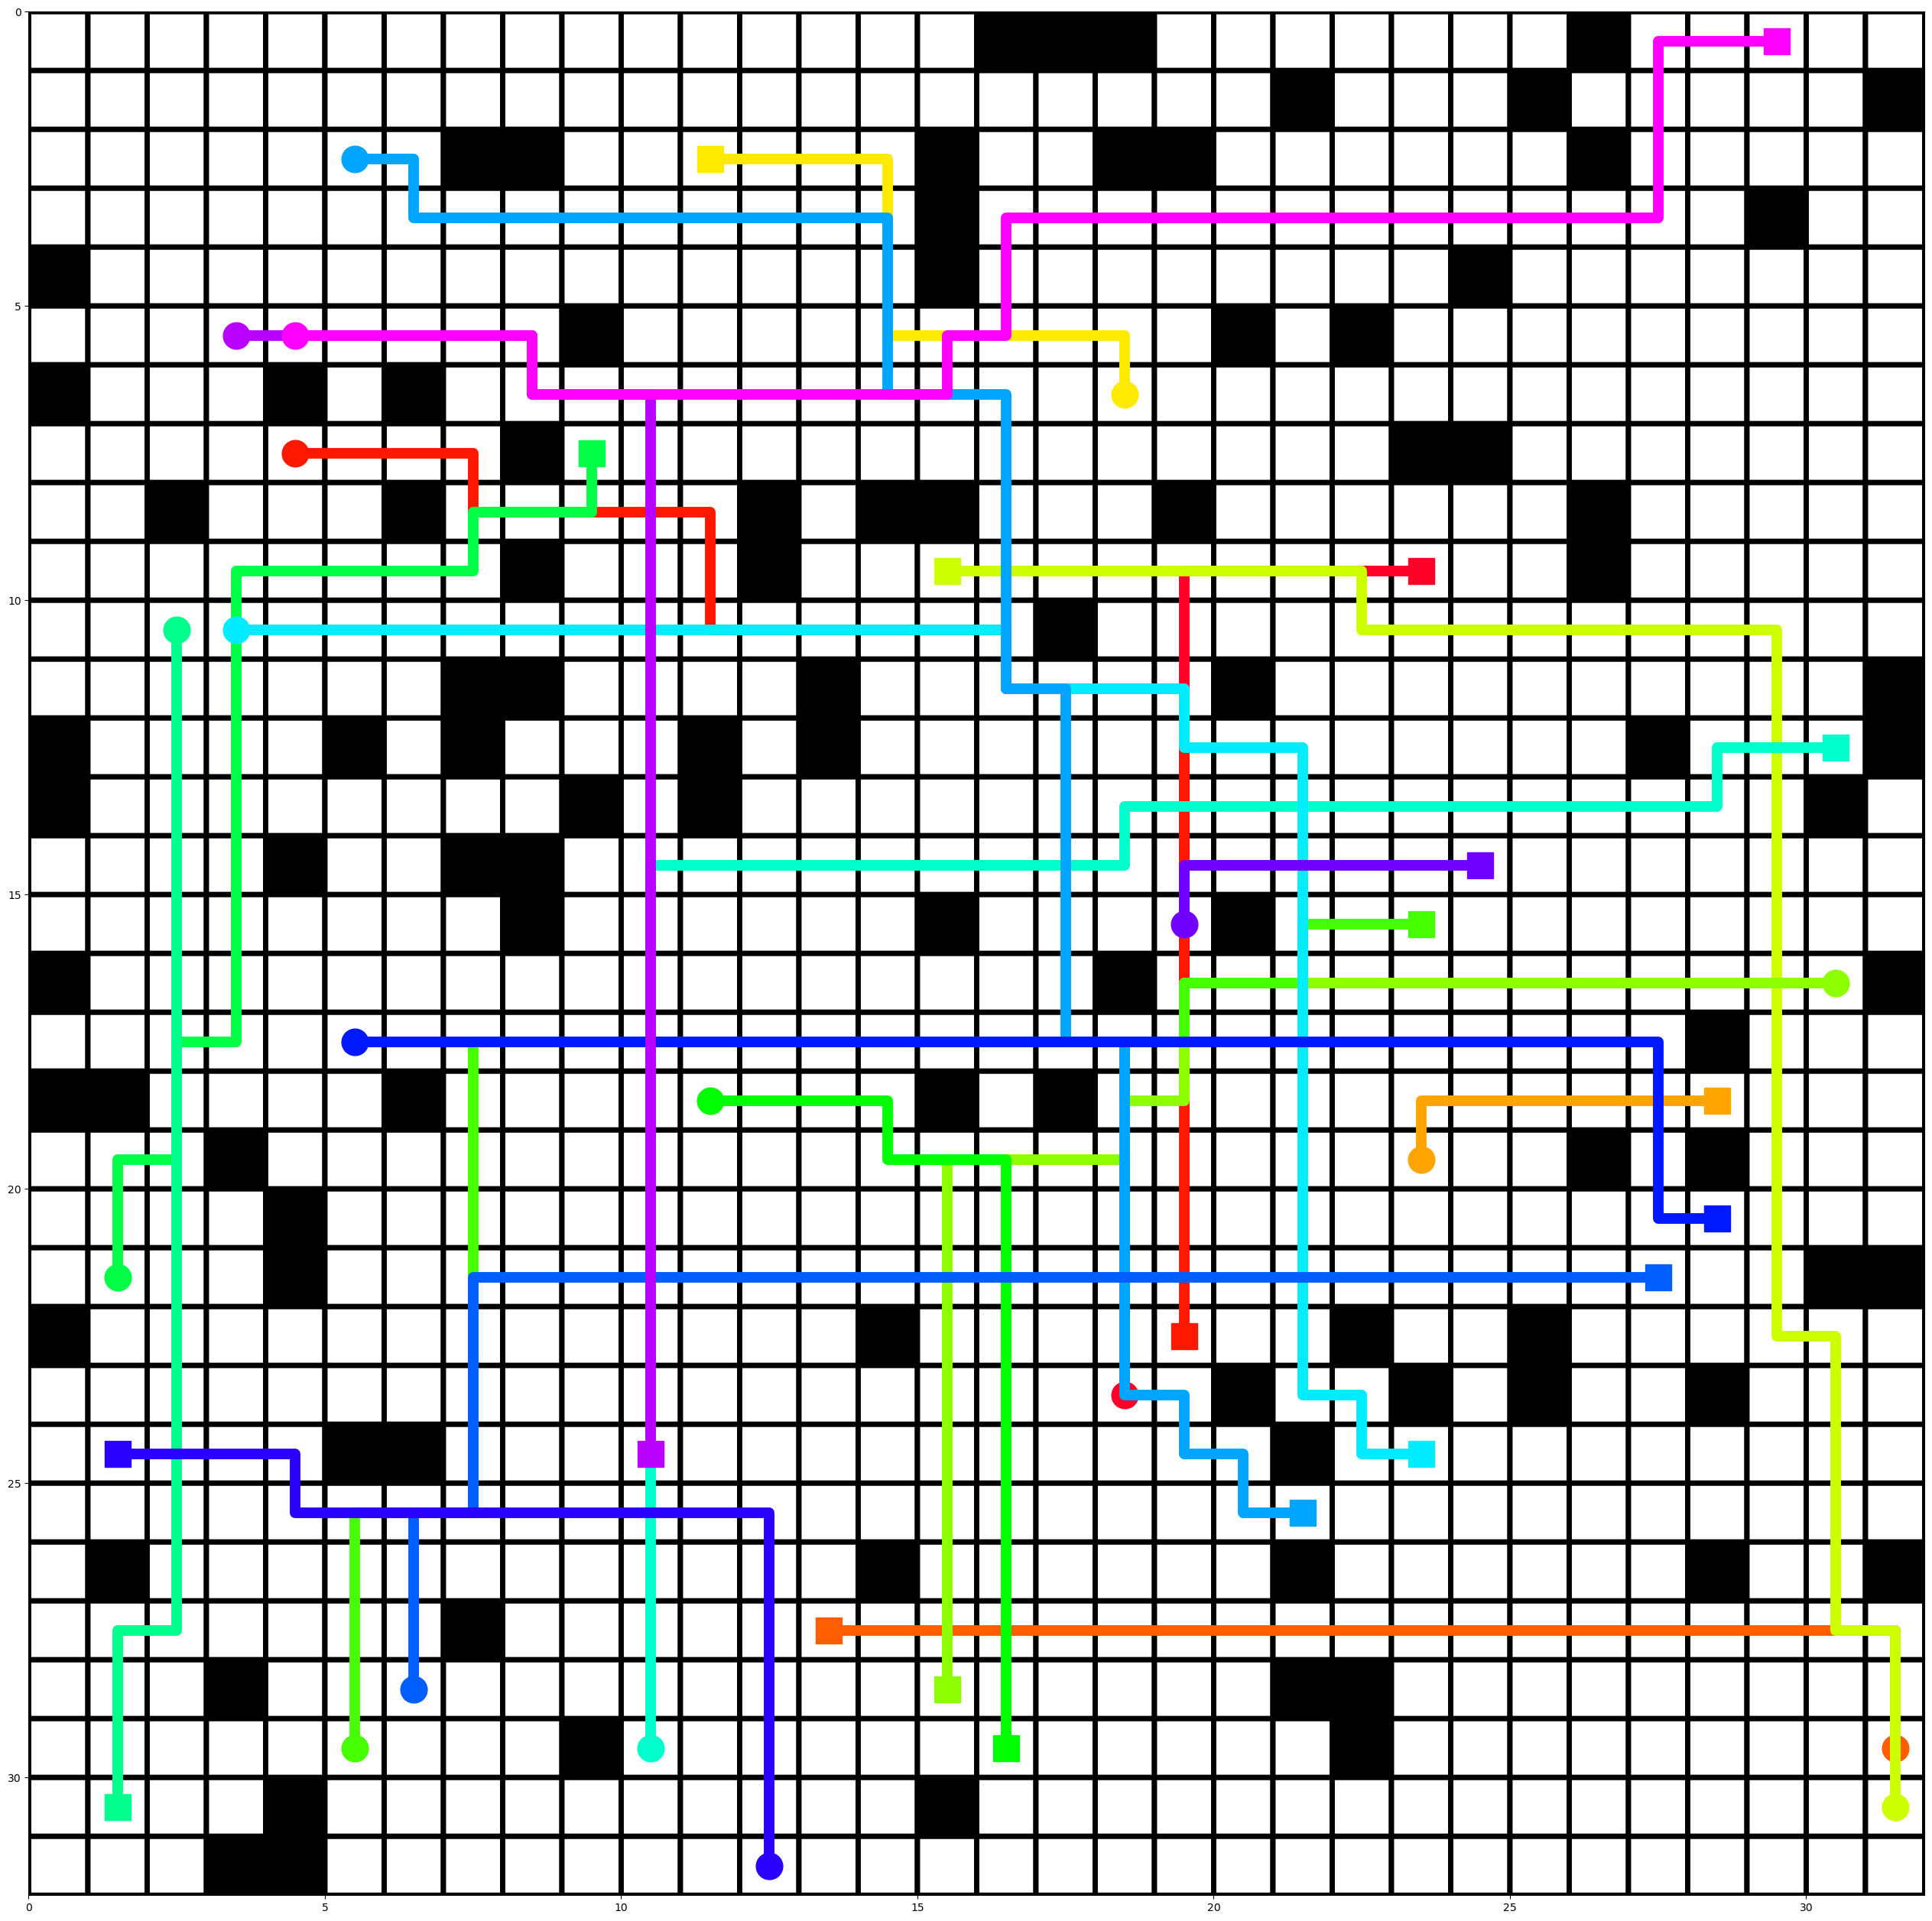

In [179]:
from matplotlib import colors

map_size = np.shape(map)
int_map = np.asarray([[int(i) for i in row] for row in map])
num_agents = len(starts)

grid_cmap = colors.ListedColormap(['White', 'Black'])

fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()
plt.pcolor(int_map[::],cmap=grid_cmap,edgecolor='k',linewidths=5)

# Init agents' individual color
agent_cmap = plt.get_cmap('gist_rainbow')
label_list = ["agent {}".format(str(i)) for i in range(num_agents)]

save_path = "/home/railab/Workspace/CCBS/Train_results/Overfitting/path_plot/icbs_path_plot.png" 

for i, (path, start, goal, label) in enumerate(zip(icbs_path, starts, goals, label_list)):
    # Plot agents
    # Start : circle, Goal : square
    # print(i/num_agents)
    c = agent_cmap(i/num_agents)
    plt.plot(start[1] + 0.5, start[0] + 0.5, marker='o', markersize=25, color=c, label=label)
    plt.plot(goal[1] + 0.5, goal[0] + 0.5, marker='s', markersize=25, color=c)

    path = np.asarray(path)
    plt.plot(path[:,1] + 0.5, path[:,0] + 0.5, color=c, linewidth=10.0)
    
plt.savefig(save_path)

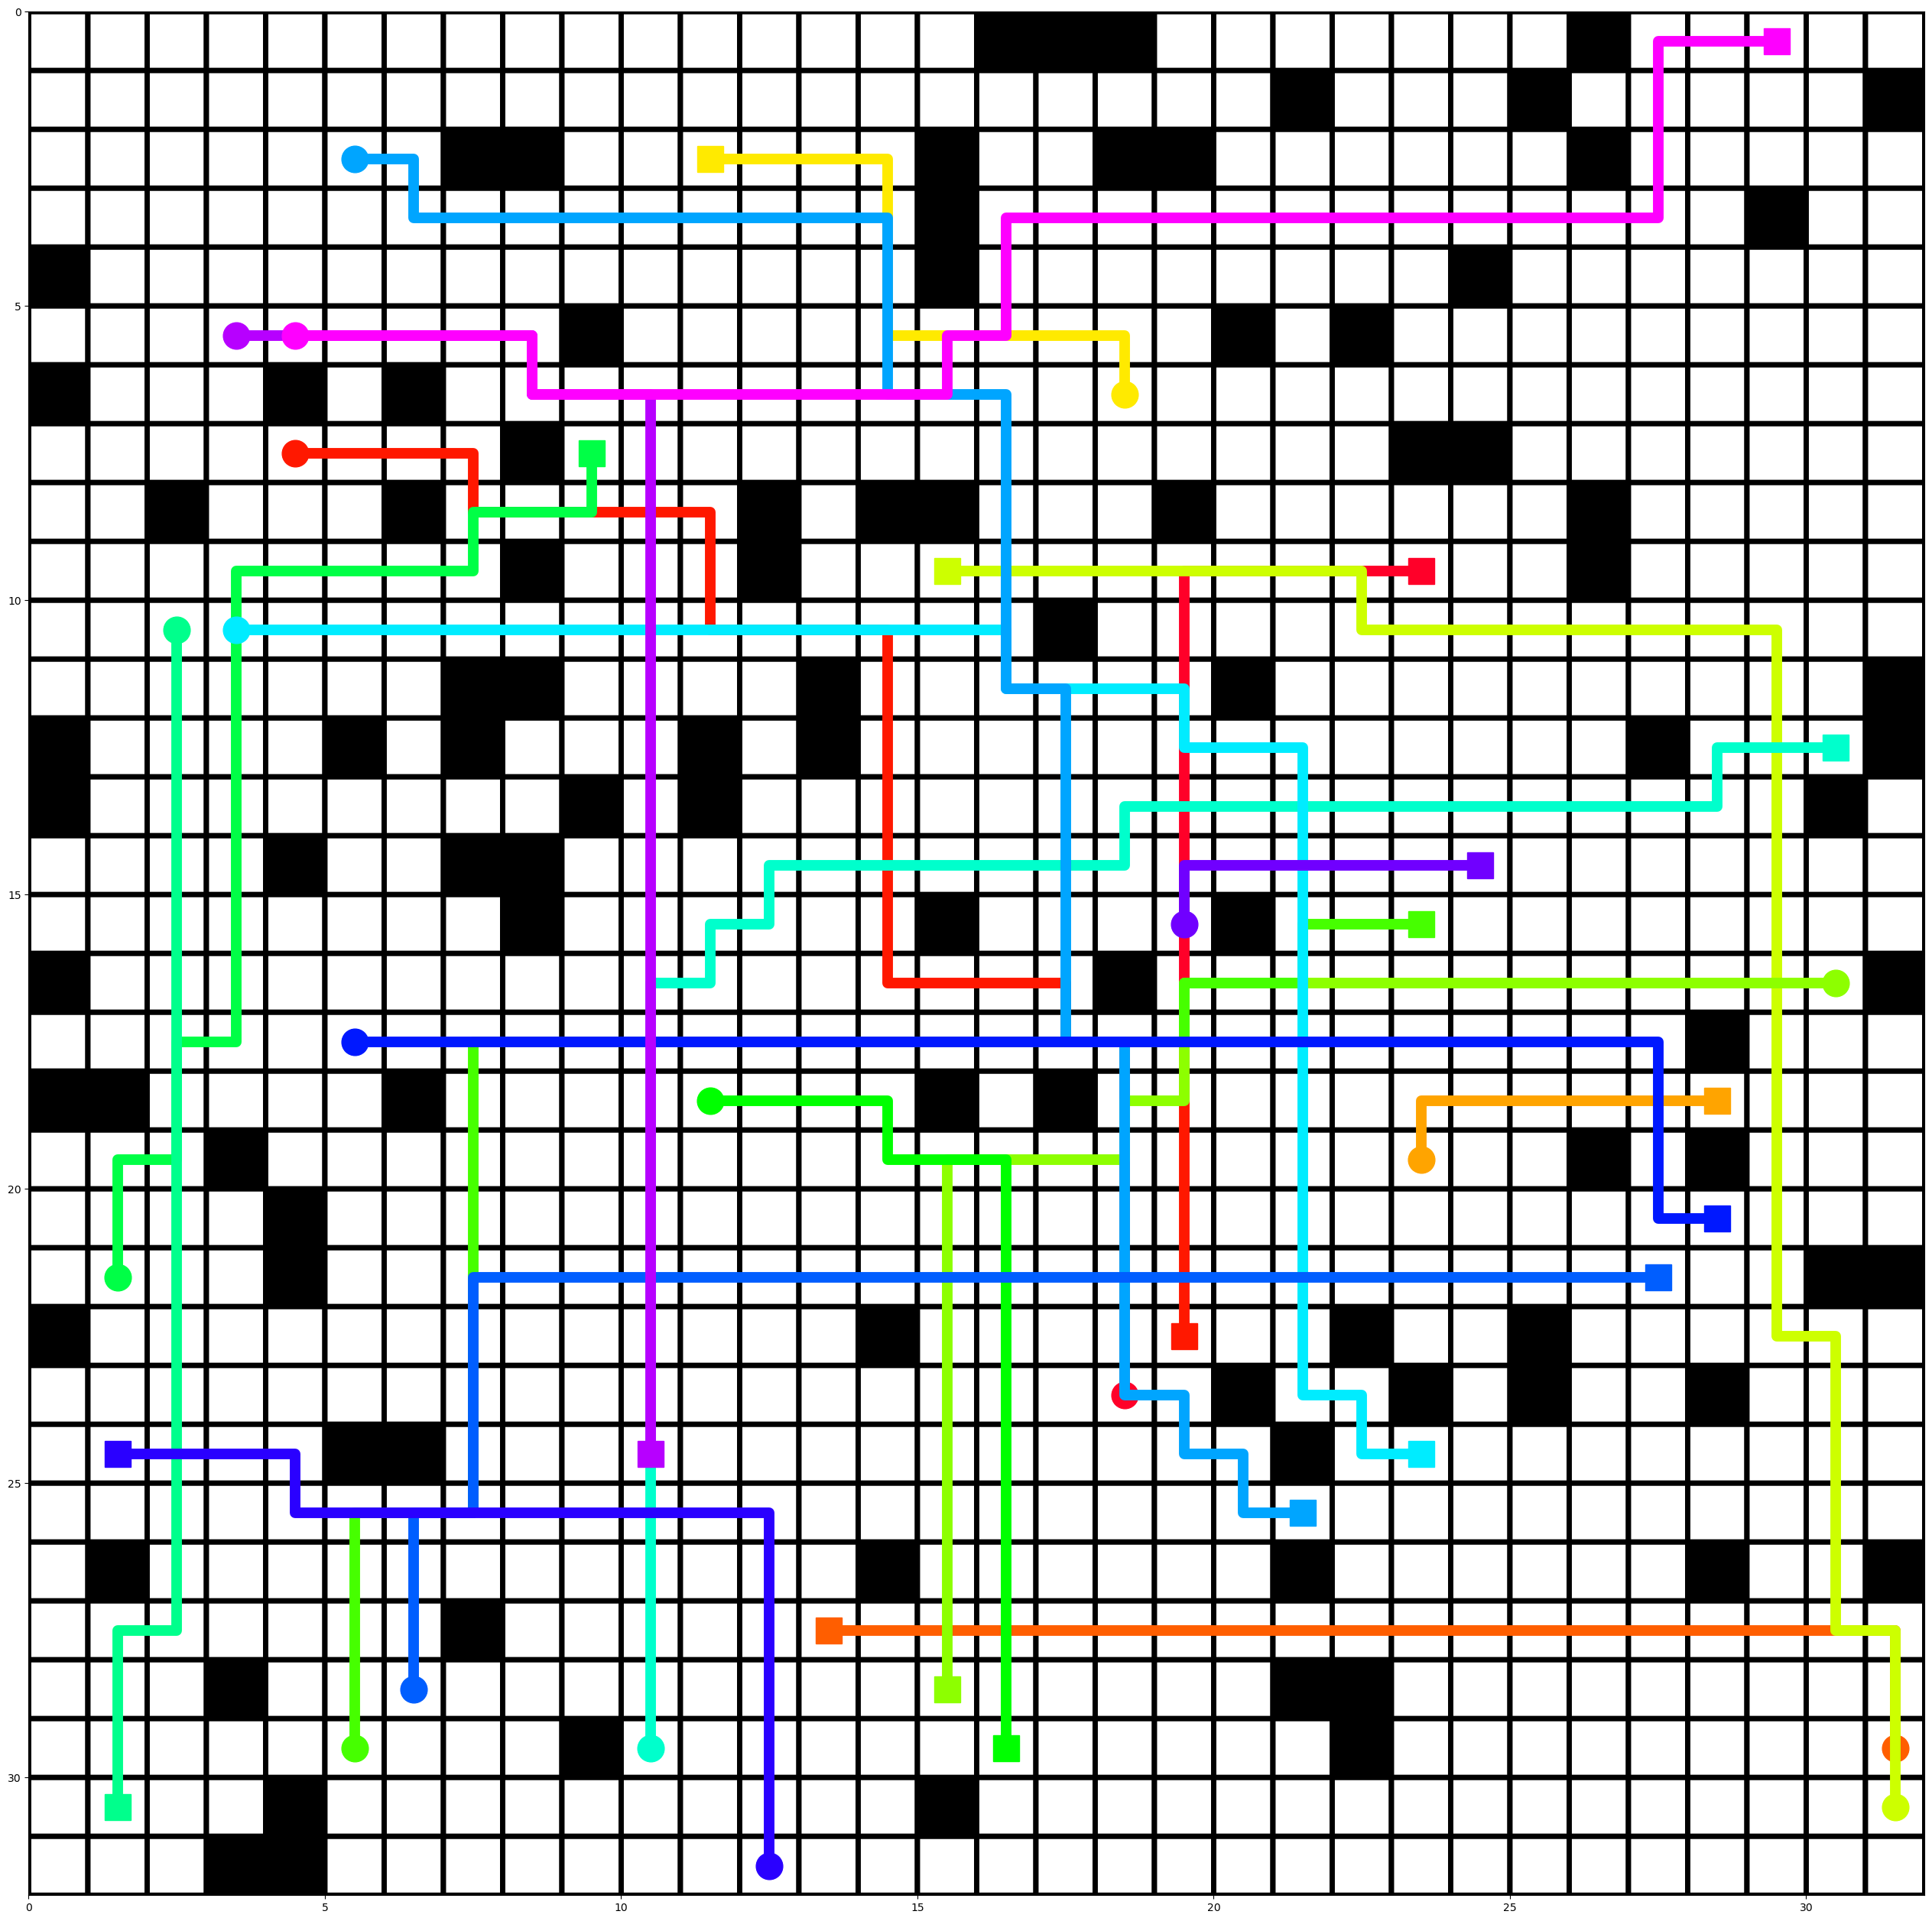

In [180]:
from matplotlib import colors

map_size = np.shape(map)
int_map = np.asarray([[int(i) for i in row] for row in map])
num_agents = len(starts)

grid_cmap = colors.ListedColormap(['White', 'Black'])

fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()
plt.pcolor(int_map[::],cmap=grid_cmap,edgecolor='k',linewidths=5)

# Init agents' individual color
agent_cmap = plt.get_cmap('gist_rainbow')
label_list = ["agent {}".format(str(i)) for i in range(num_agents)]

for i, (path, start, goal, label) in enumerate(zip(l_cbs_path, starts, goals, label_list)):
    # Plot agents
    # Start : circle, Goal : square
    # print(i/num_agents)
    c = agent_cmap(i/num_agents)
    plt.plot(start[1] + 0.5, start[0] + 0.5, marker='o', markersize=25, color=c, label=label)
    plt.plot(goal[1] + 0.5, goal[0] + 0.5, marker='s', markersize=25, color=c)

    path = np.asarray(path)
    plt.plot(path[:,1] + 0.5, path[:,0] + 0.5, color=c, linewidth=10.0)

In [159]:
primal_path = [
    [(23, 18), (22, 18), (21, 18), (20, 18), (19, 18), (18, 18), (17, 18), (17, 19), (16, 19), (15, 19), (14, 19), (13, 19), (12, 19), (11, 19), (10, 19), (9, 19), (9, 20), (9, 21), (9, 22)], 
    [(7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (13, 5), (14, 5), (14, 6), (15, 6), (15, 7), (15, 7), (16, 7), (17, 7), (18, 7), (19, 7), (20, 7), (20, 6), (21, 6), (21, 7), 
      (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 12), (21, 14), (21, 14), (21,15), (22, 15), (22, 15), (22, 17), (22, 18), (22, 18)], 
    [(29, 31), (28, 31), (27, 31), (27, 30), (27, 29), (27, 28), (27, 27), (27, 26), (27, 25), (27, 24), (27, 23), (27, 22), (27, 21), (27, 20), (27, 19), (27, 18), (27, 17), (27, 16), (27, 15), (27, 14)], 
    [(19, 23), (18, 23), (18, 24), (18, 25), (18, 26), (18, 26), (18, 26), (18, 27)], 
    [(6, 18), (6, 17), (5, 17), (5, 16), (5, 15), (5, 14), (4, 14), (3, 14), (2, 14), (2, 13), (2, 12)], 
    [(30, 31), (30, 30), (29, 30), (28, 30), (28, 29), (29, 29), (29, 28), (29, 28), (28, 28), (27, 28), (27, 27), (26, 27), (25, 27), (24, 27), (24, 26), (24, 25), (24, 24), (23, 24), (22, 24), (21, 24), 
     (20, 24), (20, 23), (20, 23), (18, 23), (17, 23), (16, 23), (15, 23), (14, 23), (14, 23), (13, 23), (12, 23), (11, 23), (11, 23), (10, 23), (10, 22), (9, 22), (9, 23), (10, 23), (10, 23), (10, 22), (10,23), (9, 23), 
     (8, 23), (8, 23), (8, 22), (9, 22), (9, 21), (10, 21), (10, 21), (10, 19), (9, 19), (9, 19), (9, 18), (9, 16), (9, 16), (9, 15)], 
    [(16, 30), (17, 30), (17, 29), (18, 29), (18, 28), (18, 27), (19, 27), (20, 27), (20, 26), (20, 25), (20, 24), (20, 23), (20, 22), (20, 21), (21, 21), (22, 21), (23, 21), (23, 22), (24, 22), (25, 22), 
     (27, 22), (27, 22), (27, 20), (27, 20), (27, 18), (27, 17), (27, 16), (27, 16), (27, 15), (28, 15)], 
    [(29, 5), (28, 5), (27, 5), (26, 5), (25, 5), (25, 6), (25, 7), (25, 8), (24, 8), (24, 9), (23, 9), (22, 9), (21, 9), (20, 9), (19, 9), (18, 9), (17, 9), (16, 9), (15, 9), (14, 9), (14, 10), (14, 10), 
     (14, 12), (14, 13), (14, 14), (14, 15), (14, 15), (14, 16), (14, 18), (14, 19), (14, 19), (14, 21), (14, 21), (14, 22), (15, 22)], 
    [(18, 11), (19, 11), (20, 11), (21, 11), (22, 11), (23, 11), (24, 11), (25, 11), (26, 11), (27, 11), (28, 11), (29, 11), (29, 12), (29, 13), (29, 14), (29, 15)], 
    [(21, 1), (20, 1), (19, 1), (19, 2), (18, 2), (17, 2), (17, 3), (17, 4), (17, 5), (17, 6), (17, 7), (16, 7), (16, 8), (16, 9), (17, 9), (17, 8), (17, 7), (17, 6), 
     (16, 6), (15, 6), (13, 6), (13, 6), (11, 6), (10, 6), (9, 6), (9, 7), (8, 7), (8, 7), (7, 7), (5, 7), (5, 8), (6, 8), (6, 8), (6, 9)], 
    [(10, 2), (11, 2), (12, 2), (13, 2), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (21, 2), (22, 2), (23, 2), (24, 2), (25, 2), (26, 2), (27, 2), (27, 1), (28, 1), (30, 1)], 
    [(29, 10), (28, 10), (27, 10), (26, 10), (25, 10), (24, 10), (23, 10), (22, 10), (21, 10), (20, 10), (19, 10), (18, 10), (17, 10), (16, 10), (15, 10), (14, 10), (14, 11), (14, 12), (14, 13), 
     (14, 14), (14, 16), (14, 16), (14, 18), (13, 18), (13, 19), (13, 20), (13, 21), (13, 21), (13, 22), (12, 22), (12, 21), (11, 21), (11, 21), (10, 21), (9, 21), (8, 21), (8, 20), (8, 20), (9, 20), (10, 20), (10, 21), 
     (10, 21), (10, 22), (11, 22), (11, 23), (11, 23), (11, 24), (11, 25), (11, 26), (11, 27), (11, 28), (11,29), (12, 29), (12, 29)], 
    [(10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (16, 4), (15, 4), (15, 5), (16, 5), (17, 5), (18, 5), 
     (19, 5), (20, 5), (21, 5), (21, 6), (21, 7), (21, 8), (21, 9), (21, 11), (21, 11), (21, 13), (21, 14), (21, 15), (22, 15), 
     (23, 15), (23, 15), (25, 15), (25, 16), (25, 17), (25, 18), (25, 18), (25, 19), (25, 20), (25, 21), (25, 22), (24, 22)], 
    [(2, 5), (3, 5), (4, 5), (5, 5), (6, 5), (7, 5), (7, 6), (7, 7), (8, 7), (9, 7), (10, 7), (10, 8), (10, 9), (11, 9), (12, 9), 
     (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (18, 10), (18, 10), (20, 10), (20, 11), (19, 11), (18, 11), (18, 11), (18, 11), 
     (20, 11), (21, 11), (22, 11), (23, 11), (23, 11), (24, 11), (25, 11), (25, 13), (25, 13), (25, 14), (25, 15), (25, 17), (25, 18), 
     (25, 18), (25, 20), (25, 21)],
    [(28, 6), (27, 6), (26, 6), (25, 6), (25, 7), (24, 7), (23, 7), (22, 7), (21, 7), (21, 8), (21, 9), (21, 10), (21, 11), (21, 12), (21, 13), (21, 14), (21, 15), (21, 16), (21, 17), (21, 18), 
     (21, 20), (21, 20), (21, 22), (21, 23), (21, 23), (21, 25), (21, 26), (21, 26)], 
    [(17, 5), (18, 5), (19, 5), (20, 5), (21, 5), (21, 6), (21, 7), (21, 8), (20, 8), (20, 9), (20, 9), (20, 10), (20, 11), (20, 12), (20, 13), (20, 14), (20, 15), (20, 16), (20, 17), (20, 18), 
     (20, 19), (20, 20), (20, 22), (20, 23), (20, 24), (20, 25), (20, 26), (20, 26), (20, 28)], 
    [(31, 12), (30, 12), (29, 12), (28, 12), (27, 12), (26, 12), (25, 12), (25, 12), (24, 12), (23, 12), (23, 11), (24, 11), (24, 10), (24, 9), (24, 8), (24, 7), (25, 7), (25, 6), (25, 5), 
     (25, 4), (25,3), (24, 3), (24, 3), (24, 2)], 
    [(15, 19), (14, 19), (13, 19), (13, 20), (14, 20), (14, 21), (14, 22), (14, 23)], 
    [(5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 3), (15, 3), (16, 3), (17, 3), (18, 3), (18, 4), (19, 4), (19, 5), (19, 6), (19, 6), (19, 7), (20, 7), (20, 7), (22, 7), (23, 7), (24, 7), (24, 8), (24, 9), (24, 9)], 
    [(5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 8), (6, 8), (6, 7), (5, 7), (4, 7), (3, 7), (3, 8), (4, 8), (4, 9), (4, 10), (4, 11), (5, 11), (5, 12), (5, 13), 
     (5, 14), (5, 16), (5, 16), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 20), (3, 22), (3, 23), (3, 24), (3, 25), (3, 25), (3, 26), (3, 27), (3,28), (2, 28), (2, 28), (2, 29), (0, 29)]
     ]



In [161]:
# print(starts[3])
# print(goals[3])
# print(primal_path[3])

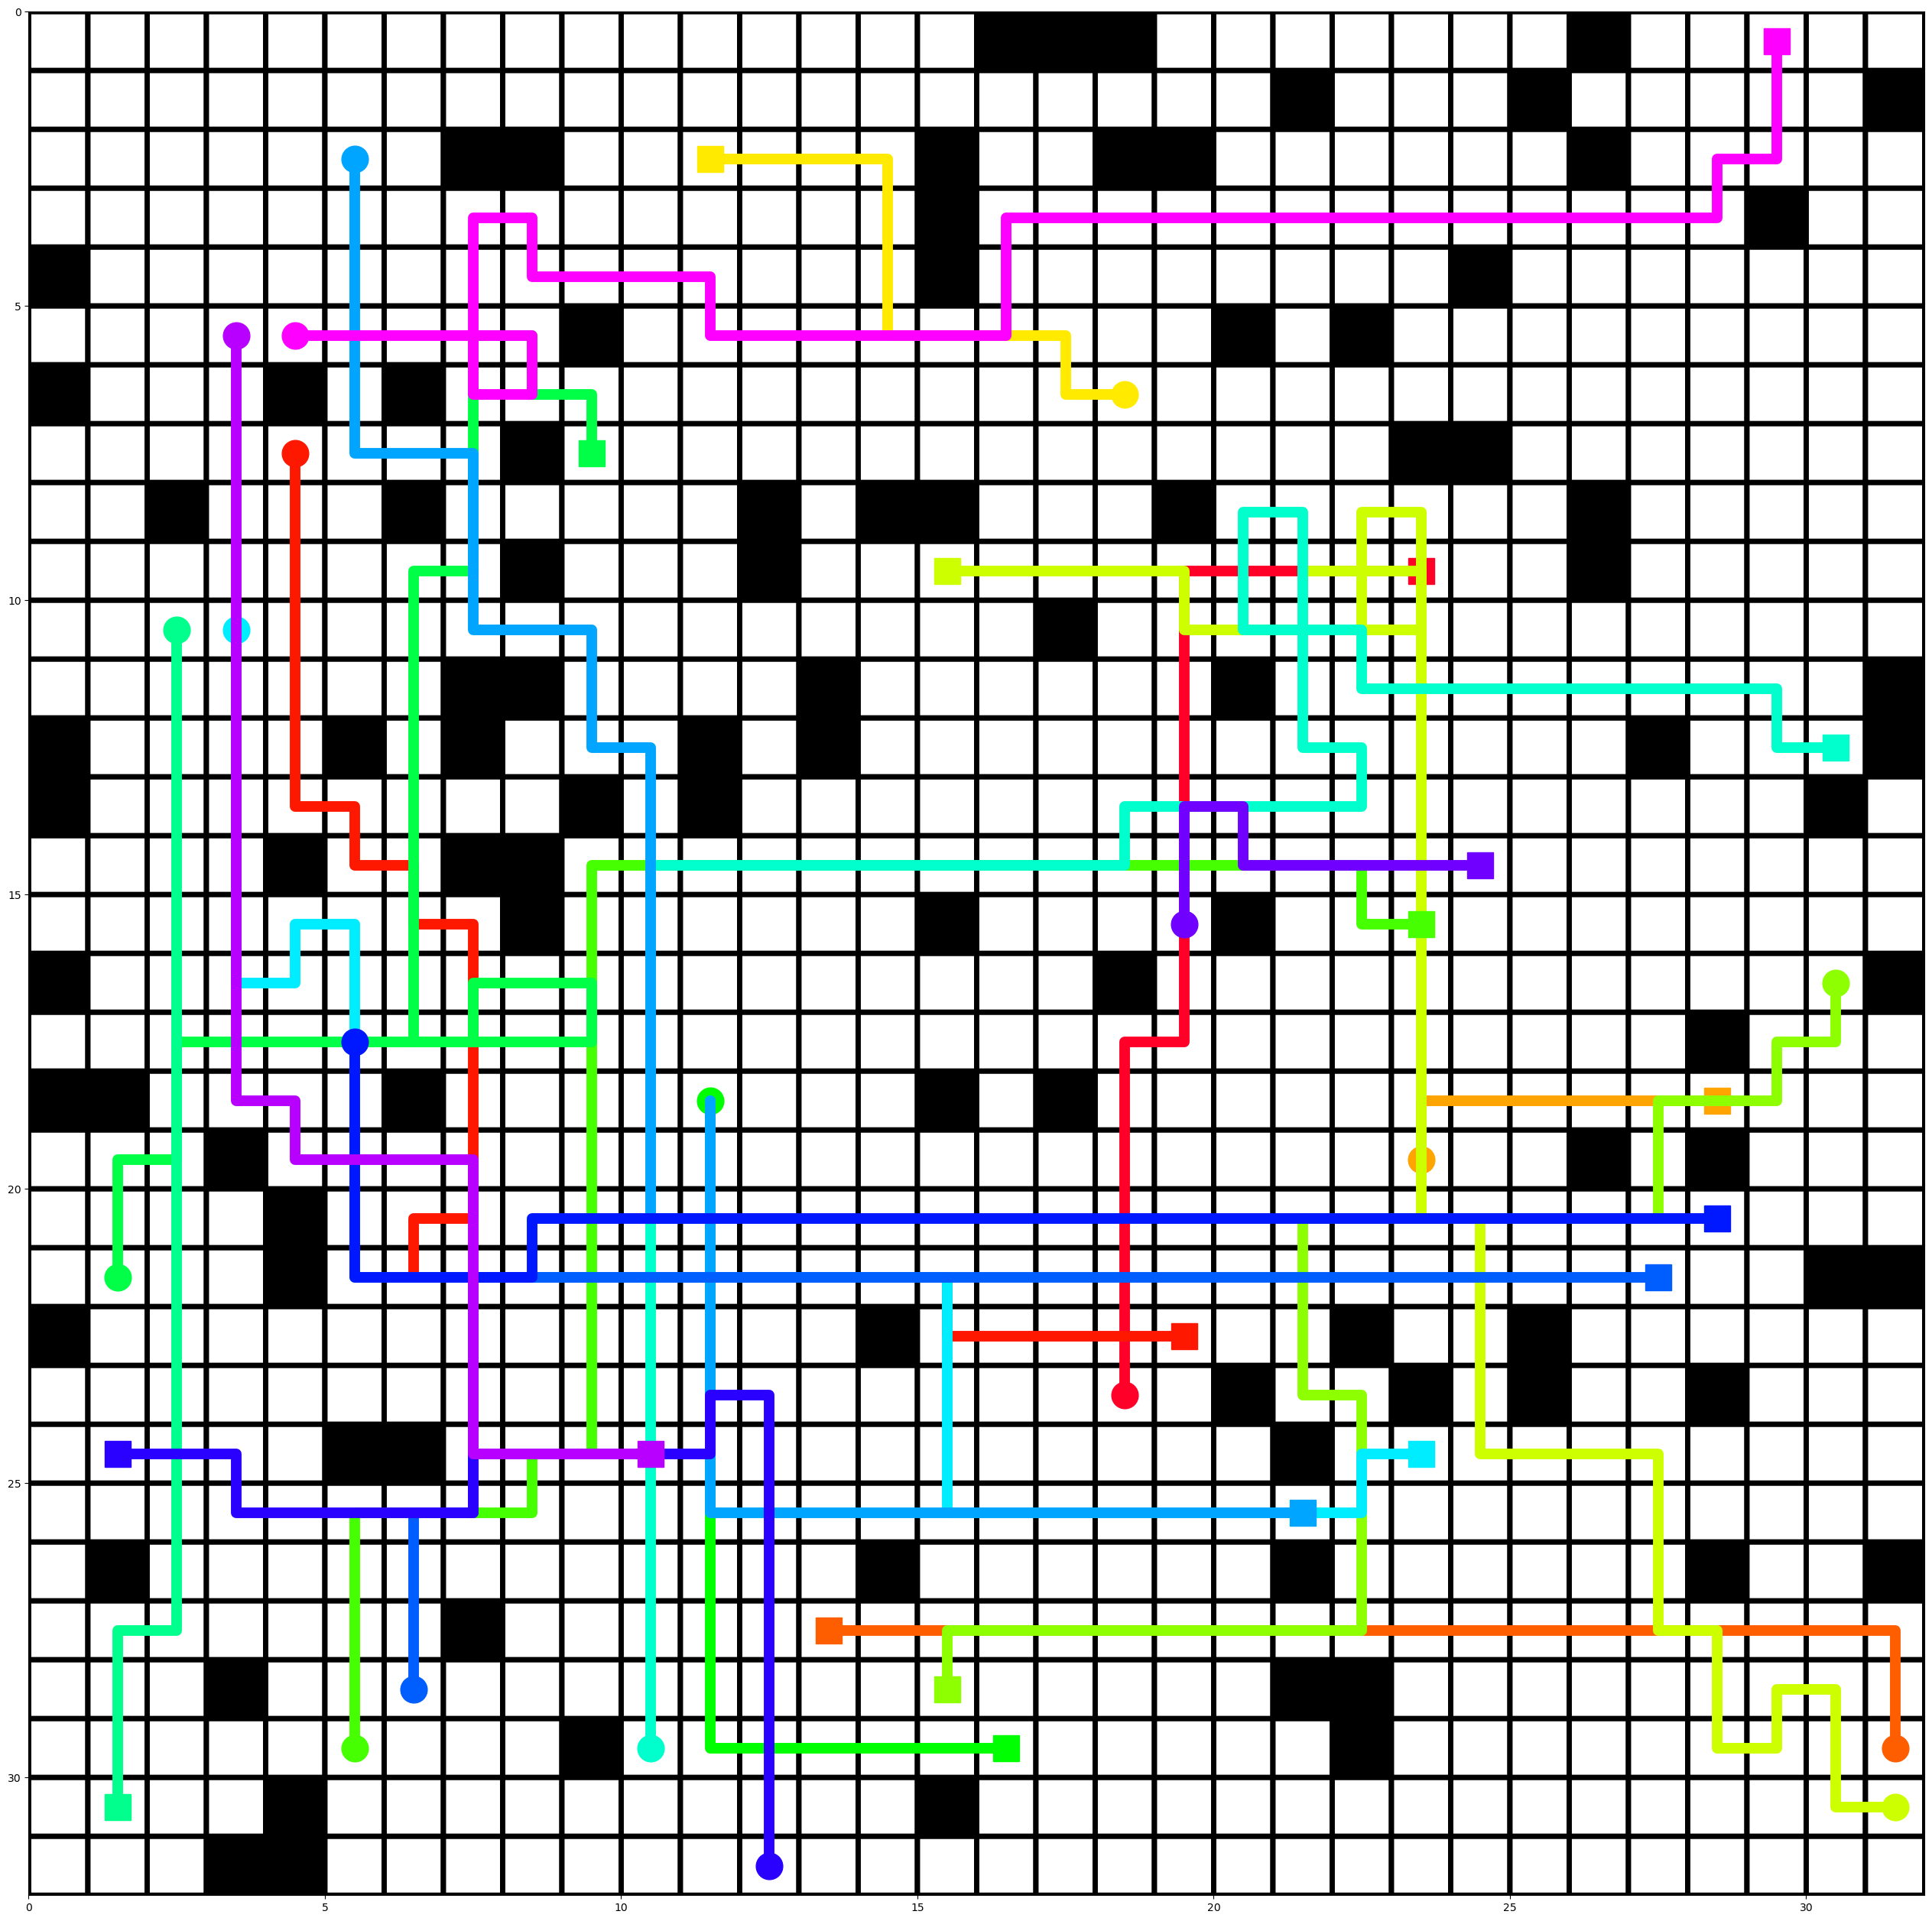

In [181]:
from matplotlib import colors

map_size = np.shape(map)
int_map = np.asarray([[int(i) for i in row] for row in map])
num_agents = len(starts)

grid_cmap = colors.ListedColormap(['White', 'Black'])

fig = plt.figure(figsize=map_size)
ax = fig.add_subplot(1,1,1)
ax.invert_yaxis()
plt.pcolor(int_map[::],cmap=grid_cmap,edgecolor='k',linewidths=5)

# Init agents' individual color
agent_cmap = plt.get_cmap('gist_rainbow')
label_list = ["agent {}".format(str(i)) for i in range(num_agents)]

for i, (path, start, goal, label) in enumerate(zip(primal_path, starts, goals, label_list)):
    # if i == 19:
    #     print(path)
    # Plot agents
    # Start : circle, Goal : square
    # print(i/num_agents)
    c = agent_cmap(i/num_agents)
    plt.plot(start[1] + 0.5, start[0] + 0.5, marker='o', markersize=25, color=c, label=label)
    plt.plot(goal[1] + 0.5, goal[0] + 0.5, marker='s', markersize=25, color=c)

    path = np.asarray(path)
    plt.plot(path[:,1] + 0.5, path[:,0] + 0.5, color=c, linewidth=10.0)

In [166]:
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0 -1]
 [ 0  0  0  0  0 14  0 -1 -1  0  0  0  0  0  0 -1  0  0 -1 -1  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0]
 [ 0  0  0 19 20  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0 -1  0  0  0  0  0 -1  0 -1 -1  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
 [ 0  0 11 13  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1 -1  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0 -1  0 -1  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]
 [ 0  0  0  0 -1  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0 18 -1  0  0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  7 -1]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0]
 [-1 -1  0  0  0  0 -1  0  0  0  0  9  0  0  0 -1  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0 -1  0 -1  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0 -1  0  0 -1  0 -1  0  0 -1  0  0  0]
 [ 0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0  0 -1]
 [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0 -1 12  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  3]
 [ 0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6]
 [ 0  0  0 -1 -1  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]

(23, 18), (7, 4), (29, 31), (19, 23), (6, 18), (30, 31), (16, 30), (29, 5), (18, 11), (21, 1), (10, 2), (29, 10), (10, 3), (2, 5), (28, 6), (17, 5), (31, 12), (15, 19), (5, 3), (5, 4)

SyntaxError: invalid syntax (920816915.py, line 1)

In [53]:
print(starts)
print(goals)
for path in primal_path:
    print(path)

[(23, 18), (7, 4), (29, 31), (19, 23), (6, 18), (30, 31), (16, 30), (29, 5), (18, 11), (21, 1), (10, 2), (29, 10), (10, 3), (2, 5), (28, 6), (17, 5), (31, 12), (15, 19), (5, 3), (5, 4)]
[(9, 23), (22, 19), (27, 13), (18, 28), (2, 11), (9, 15), (28, 15), (15, 23), (29, 16), (7, 9), (30, 1), (12, 30), (24, 23), (25, 21), (21, 27), (20, 28), (24, 1), (14, 24), (24, 10), (0, 29)]
[(23, 18), (22, 18), (21, 18), (20, 18), (19, 18), (18, 18), (17, 18), (17, 19), (16, 19), (15, 19), (14, 19), (13, 19), (12, 19), (11, 19), (10, 19), (9, 19), (9, 20), (9, 21), (9, 22)]
[(7, 4), (8, 4), (9, 4), (10, 4), (11, 4), (12, 4), (13, 4), (13, 5), (14, 5), (14, 6), (15, 6), (15, 7), (15, 7), (16, 7), (17, 7), (18, 7), (19, 7), (20, 7), (20, 6), (21, 6), (21, 8), (21, 8), (21, 10), (21, 11), (21, 12), (21, 12), (21, 14), (21, 14), (22, 15), (22, 15), (22, 17), (22, 18), (22, 18)]
[(29, 31), (28, 31), (27, 31), (27, 30), (27, 29), (27, 28), (27, 27), (27, 26), (27, 25), (27, 24), (27, 23), (27, 22), (27, 21